In [2]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
from matplotlib.patches import Patch
from scipy.stats import wilcoxon
from picconfig import predpath, survpath, phecatpath, outputpath, numericpath

In [3]:
cats='''Intestine,Digestive
Genital,Reproductive
Oral,Sensory
Upper digestive,Digestive
Digestive gland,Digestive
Bone and soft tissues,Tissues
Skin,Sensory
Urinary,Urinary
Eye,Sensory
CNS,Nervous
Endocrine,Endocrine
Blood,Circulatory
Vessel,Circulatory
Mental,Nervous
PNS,Nervous
Ear,Sensory
Heart,Circulatory
Upper respiratory,Respiratory
Lung,Respiratory
Pregnancy,Reproductive
Microbe,Externalities'''.split('\n')
catsd={}
for i in cats:
    if i.split(',')[1] in catsd.keys():
        catsd[i.split(',')[1]]+=[i.split(',')[0]]
    else:
        catsd[i.split(',')[1]]=[i.split(',')[0]]
phecat=np.load(phecatpath, allow_pickle=1)[0]
finalcat={}
for k,v in catsd.items():
    temp=[]
    for i in v:
        temp+=list(phecat[i])
    finalcat[k]=np.array(temp)
finalcat.keys()

dict_keys(['Digestive', 'Reproductive', 'Sensory', 'Tissues', 'Urinary', 'Nervous', 'Endocrine', 'Circulatory', 'Respiratory', 'Externalities'])

In [4]:
raw={}
for i in os.listdir(predpath):
    if i.endswith('.npy'):
        if not i.endswith('lab.npy'):
            if not i.endswith('out.npy'):
                if not i.endswith('trainauc.npy'):
                    raw[i.split('.')[0]]=np.load(predpath+i)
best_perf={}
for i in range(1,7):
    for j in range(4):
        for k in range(1):
            temp=0
            mx=''
            for name in sorted(raw.keys()):
                if name[:3]==f'{i}{j}{k}':
                    if np.nanmean(raw[name])>=temp:
                        mx=name
                        temp=np.nanmean(raw[name])
            best_perf[f'{i}{j}{k}']=mx

In [5]:
best_perf

{'100': '100_3',
 '110': '110_7',
 '120': '120_9',
 '130': '130_2',
 '200': '200_4',
 '210': '210_6',
 '220': '220_9',
 '230': '230_4',
 '300': '300_2',
 '310': '310_3',
 '320': '320_9',
 '330': '330_4',
 '400': '400_3',
 '410': '410_6',
 '420': '420_9',
 '430': '430_6',
 '500': '500_3',
 '510': '510_6',
 '520': '520_9',
 '530': '530_4',
 '600': '600_5',
 '610': '610_6',
 '620': '620_9',
 '630': '630_5'}

In [6]:
# load FCNN
f1 = np.load(predpath+best_perf['110']+".npy")
f2 = np.load(predpath+best_perf['210']+".npy")
f3 = np.load(predpath+best_perf['310']+".npy")
f4 = np.load(predpath+best_perf['410']+".npy")
f5 = np.load(predpath+best_perf['510']+".npy")
f6 = np.load(predpath+best_perf['610']+".npy")
# load DS
s1 = np.load(survpath+"110_0.npy")
s2 = np.load(survpath+"210_0.npy")
s3 = np.load(survpath+"310_0.npy")
s4 = np.load(survpath+"410_0.npy")
s5 = np.load(survpath+"510_0.npy")
s6 = np.load(survpath+"610_0.npy")

In [7]:
def draw_pilot(ax, title, data, left, right, cm, rows, rowheight, words, ticks, base=0.2, prop=1.7):
    center = 0.7 * left + 0.3 * right
    plt.text(left+0.02, 1-rowheight/2, title[0], fontsize=12, fontweight=600, va='center', ha='left')
    if title[1]=='Survival':
        plt.text((center+right)/2+0.02, 1-rowheight/2, title[1], fontsize=12, fontweight=600, va='center', ha='center')
    else:
        plt.text((center+right)/2+0.02, 1-rowheight/2, title[1], fontsize=12, fontweight=600, va='center', ha='center')
    linex = (1-base) * center + base * right
    r = rowheight/14
    plt.plot([linex, linex], [(rows-1)/rows, 0], color=cm(0), scalex=False, scaley=False, linewidth=2, alpha=0.3, linestyle="--")
    for tick in ticks:
        plt.plot([linex + prop* tick, linex + prop* tick], [-0.004,-0.007], color='black', scalex=False, scaley=False)
        plt.text(linex + prop* tick, -0.01, str(tick), fontsize=9, va='top', ha='center')
    for i, d in enumerate(data):
        if i==0:
            diff = data[i]
            flag = True
        else:
            diff = data[i] - data[0]
            flag = False
        if flag:
            for j, key in enumerate(words):
                if j==0:
                    continue
                else:
                    try:
                        index = finalcat[key]
                    except:
                        index = np.array(phecat[key])
                    plt.text(left+0.05,1-(0.5+j) * rowheight,"{:.3f}".format(np.nanmedian(diff[index])), 
                             ha='left', va='center', fontsize=11)
                    temp = diff[index]
                    temp = temp[~np.isnan(temp)]
                    leftvalue = np.percentile(temp, 25) - np.median(temp)
                    medianvalue = 0
                    rightvalue = np.percentile(temp, 75) - np.median(temp)
                    height = 1-(0.5+j) * rowheight + 2.2*(i-2.1)*r
                    c = plt.Circle((linex + prop * medianvalue, height),
                                   r, color=cm(i), fill=True)
                    ax.add_patch(c)
                    ax.plot([linex + prop * leftvalue, linex + prop * rightvalue], [height, height], 
                            color=cm(i), scalex=False, scaley=False)
        else:
            for j, key in enumerate(words):
                if j==0:
                    continue
                else:
                    try:
                        index = finalcat[key]
                    except:
                        index = np.array(phecat[key])
                    temp = diff[index]
                    temp = temp[~np.isnan(temp)]
                    leftvalue = np.percentile(temp, 25)
                    medianvalue = np.median(temp)
                    rightvalue = np.percentile(temp, 75)
                    height = 1-(0.55+j) * rowheight + 2.2*(i-2.1)*r
                    c = plt.Circle((linex + prop * medianvalue, height),
                                   r, color=cm(i), fill=True)
                    ax.add_patch(c)
                    ax.plot([linex + prop * leftvalue, linex + prop * rightvalue], [height, height], 
                            color=cm(i), scalex=False, scaley=False)

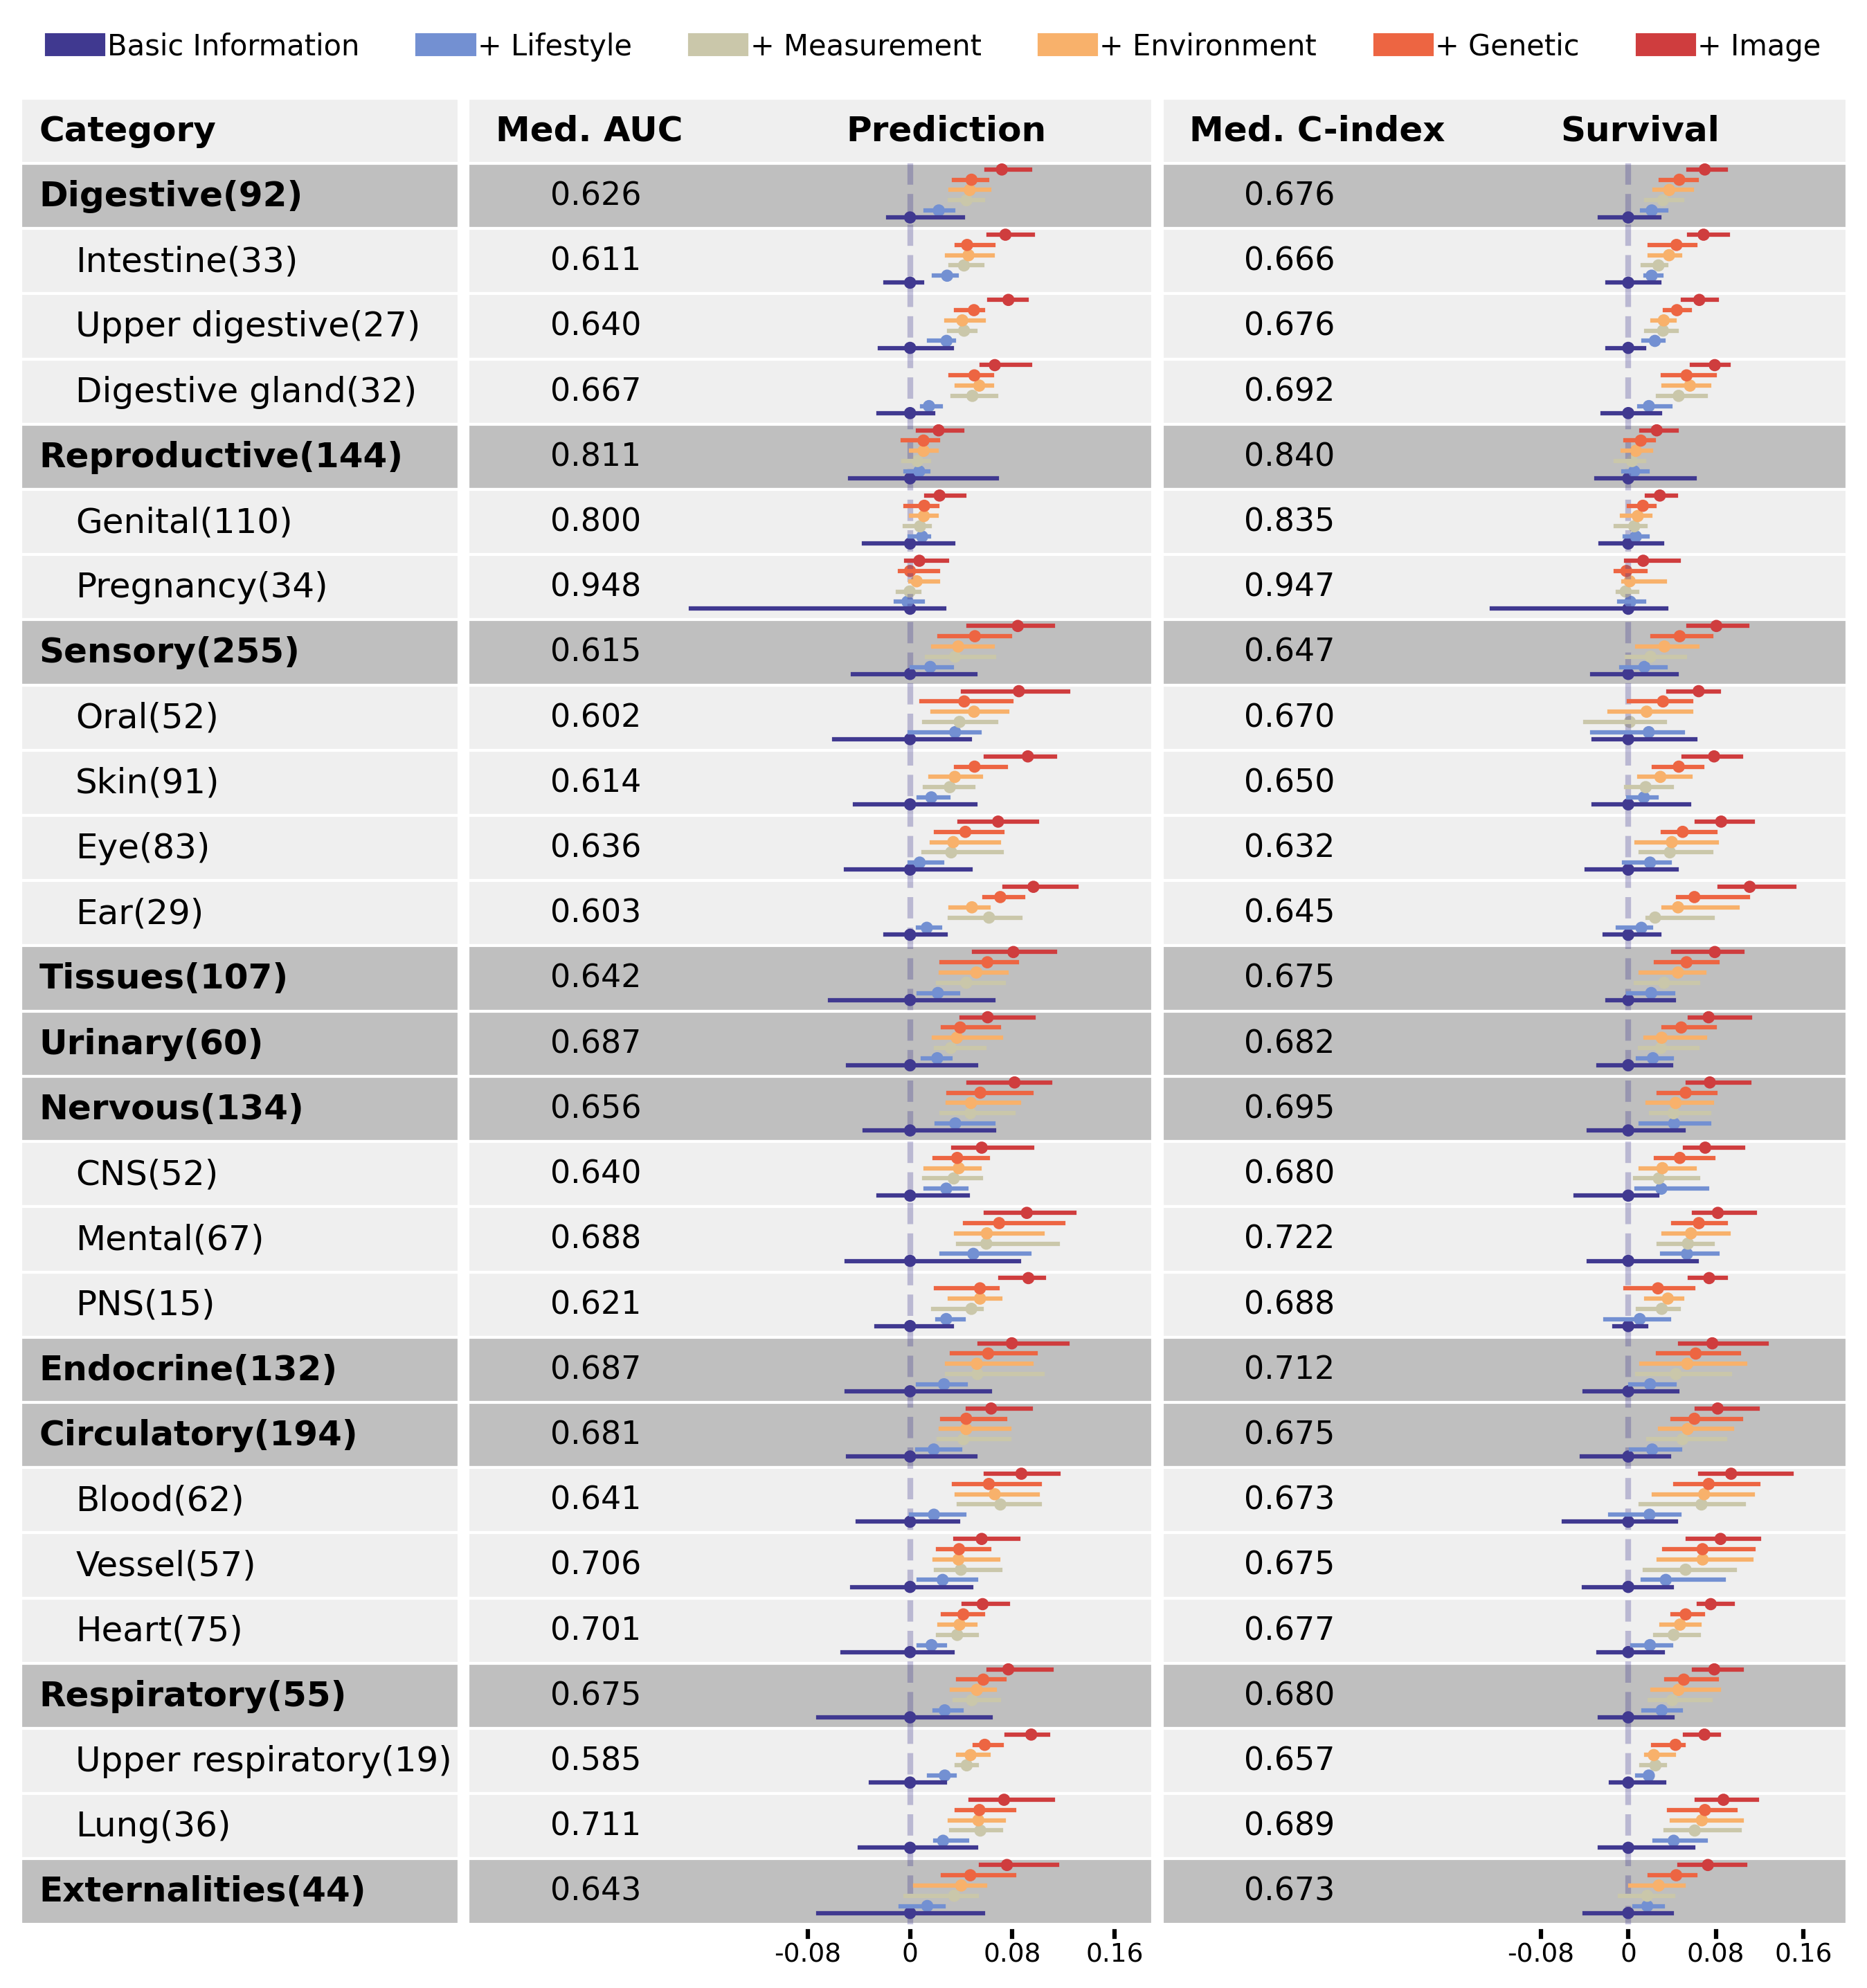

In [8]:
colors = ['#403990','#80A6E2','#FBDD85','#F46F43','#CF3D3E']
cm = LinearSegmentedColormap.from_list('Nature', colors, N=6)
plt.figure(dpi=300, figsize=(10,12))
ax = plt.gca()
ax.set_aspect('equal')
borderprop = [0, 0.24, 0.38, 0.38]
words = ['Category']
size = [12]
bold = [600]
for key, item in catsd.items():
    words += [key]
    size += [12]
    bold += [600]
    if len(item)!=1:
        words += item
        size += [12] * len(item)
        bold += [500] * len(item)
rowheight = 1/len(words)
# background
for i in range(len(borderprop)-1):
    startleft = sum(borderprop[0:(i+1)])
    long = borderprop[i+1]
    if i!=0:
        startleft += 0.005
        long = long - 0.005
    for j, b in enumerate(bold):
        startdown = 1-(j+1) * rowheight
        if j!=0 and b==600:
            rect = plt.Rectangle((startleft, startdown), long, rowheight, facecolor='#bfbfbf', fill=True, edgecolor='#ffffff')
        else:
            rect = plt.Rectangle((startleft, startdown), long, rowheight, facecolor='#efefef', fill=True, edgecolor='#ffffff')
        ax.add_patch(rect)
# column I
# text
for i, word in enumerate(words):
    if i!=0:
        try:
            index = finalcat[word]
        except:
            index = np.array(phecat[word])
        n_phe = np.sum(~np.isnan(f1[index]))
    if bold[i]==600:
        if i!=0:
            plt.text(0.01, 1-(i+1/2) * rowheight, f"{word}({n_phe})", va='center',ha='left', fontsize=size[i], fontweight = bold[i])
        else:
            plt.text(0.01, 1-(i+1/2) * rowheight, word, va='center',ha='left', fontsize=size[i], fontweight = bold[i])
    else:
        plt.text(0.03, 1-(i+1/2) * rowheight, f"{word}({n_phe})", va='center',ha='left', fontsize=size[i], fontweight = bold[i])
draw_pilot(ax, ['Med. AUC','Prediction'], [f1, f2, f3, f4, f5, f6], 0.24, 0.62, cm, len(words), rowheight, words, 
           ticks=[-0.08, 0,0.08,0.16], base=0.5, prop=0.7)
draw_pilot(ax, ['Med. C-index','Survival'], [s1, s2, s3, s4, s5, s6], 0.62, 1, cm, len(words), rowheight, words, 
     ticks=[-0.08, 0,0.08,0.16],prop=0.6, base=0.55)
plt.axis("off")
plt.ylim((-0.02,1.04))
names=['Basic Information','+ Lifestyle','+ Measurement','+ Environment','+ Genetic', '+ Image']
legend_handles=[]
for i in range(6):
    legend_handles.append(Patch(color=cm(i), label=names[i]))
legend = plt.legend(handles=legend_handles, ncol=6,fontsize=10,loc='upper center',bbox_to_anchor=(0.5, 1.01), handletextpad=0.1)
legend.get_frame().set_linewidth(0)
legend.get_frame().set_facecolor('none') 
plt.tight_layout()
plt.savefig(outputpath + "fig3_forest.pdf", format="pdf", bbox_inches="tight")
plt.show()

In [9]:
def maketable(name, data, words, alternative="greater"):
    dat = {
        'Category':[],
        '1_2':[],
        '2_3':[],
        '3_4':[],
        '4_5':[],
        '5_6':[]
    }
    n = len(data)
    flag = True
    for i in range(n-1):
        label = str(i+1) + "_" + str(i+2)
        data1 = data[i]
        data2 = data[i+1]
        for j, key in enumerate(words):
            if j==0:
                continue
            else:
                if flag:
                    dat['Category'].append(key)
                try:
                    index = finalcat[key]
                except:
                    index = np.array(phecat[key])
                temp1 = data1[index]
                temp2 = data2[index]
                index2 = (~np.isnan(temp1)) & (~np.isnan(temp2))
                temp1 = temp1[index2]
                temp2 = temp2[index2]
                _, p_value = wilcoxon(temp2, temp1, alternative=alternative)
                dat[label].append(p_value)
        flag = False
    dat = pd.DataFrame(dat)
    dat.to_csv(numericpath + name + ".csv")

In [10]:
def maketable_diff(name, data, words):
    dat = {
        'Category':[],
        'mean_1_2':[],
        'mean_2_3':[],
        'mean_3_4':[],
        'mean_4_5':[],
        'mean_5_6':[],
        'median_1_2':[],
        'median_2_3':[],
        'median_3_4':[],
        'median_4_5':[],
        'median_5_6':[],
    }
    n = len(data)
    flag = True
    for i in range(n-1):
        label = str(i+1) + "_" + str(i+2)
        data1 = data[i]
        data2 = data[i+1]
        for j, key in enumerate(words):
            if j==0:
                continue
            else:
                if flag:
                    dat['Category'].append(key)
                try:
                    index = finalcat[key]
                except:
                    index = np.array(phecat[key])
                temp1 = data1[index]
                temp2 = data2[index]
                index2 = (~np.isnan(temp1)) & (~np.isnan(temp2))
                temp1 = temp1[index2]
                temp2 = temp2[index2]
                #_, p_value = wilcoxon(temp2, temp1, alternative=alternative)
                dat["mean_"+label].append("{:.3f}".format(np.mean(temp2)-np.mean(temp1)))
                dat["median_"+label].append("{:.3f}".format(np.median(temp2)-np.median(temp1)))
        if flag:
            dat['Category'].append('All')
        indexall = (~np.isnan(data1)) & (~np.isnan(data2))
        data1 = data1[indexall]
        data2 = data2[indexall]
        dat["mean_"+label].append("{:.3f}".format(np.mean(data2)-np.mean(data1)))
        dat["median_"+label].append("{:.3f}".format(np.median(data2)-np.median(data1)))
        flag = False

    dat = pd.DataFrame(dat)
    dat.to_csv(numericpath + name + ".csv")

In [11]:
maketable('image_prediction', [f1, f2, f3, f4, f5, f6], words)
maketable('image_survival', [s1, s2, s3, s4, s5, s6], words)

In [12]:
maketable('image_prediction_two_sided', [f1, f2, f3, f4, f5, f6], words, "two-sided")
maketable('image_survival_two_sided', [s1, s2, s3, s4, s5, s6], words, "two-sided")

In [13]:
maketable_diff('image_prediction_diff', [f1, f2, f3, f4, f5, f6], words)
maketable_diff('image_survival_diff', [s1, s2, s3, s4, s5, s6], words)